In [24]:
#coding:utf-8
#生成数据集的模块
#导入模块，生成模拟数据集
import numpy as np
import matplotlib.pyplot as plt
seed=2

def generateds():
    #基于seed产生随机数
    rdm = np.random.RandomState(seed)
    #随机数返回300行2列的矩阵，表示300组坐标点(x0, x1)作为输入数据集
    X = rdm.randn(300,2)
    #从这300行2列的矩阵中取出一行，判断如果两个坐标的平方和小于2，给Y赋值1，其余赋值0
    #作为输入数据集的标签(正确答案)
    Y_ = [int(x0*x0 + x1*x1 <2) for (x0,x1) in X]

    #遍历Y中的每一个元素， 1赋值'red'其余赋值'blue',这样可视化显示时可直观区分
    Y_c = [['red' if y else 'blue'] for y in Y_]

    #对数据集X和标签Y进行整理，第一个元素为-1表示跟随第二列计算，第二个元素表示多少列，X为两列，Y为1列
    X = np.vstack(X).reshape(-1,2)
    Y_ = np.vstack(Y_).reshape(-1,1)

    return X, Y_, Y_c

In [25]:
#定义前向传播模块
import tensorflow as tf

#定义神经网络的输入、参数和输出，定义前向传播过程
def get_weight(shape, regularizer):
    w = tf.Variable(tf.random_normal(shape),dtype=tf.float32)
    tf.add_to_collection('losses', tf.contrib.layers.l2_regularizer(regularizer)(w)) #l2正则化
    return w

def get_bias(shape):
    b = tf.Variable(tf.constant(0.01, shape=shape))
    return b

def forward(x, regularizer):
     
    w1 = get_weight([2,11], regularizer)
    b1 = get_bias([11])
    y1 = tf.nn.relu(tf.matmul(x, w1) + b1)
    
    w2 = get_weight([11,1], regularizer)
    b2 = get_bias([1])
    y = tf.matmul(y1, w2) + b2 #输出层不使用激活函数
    
    return y

After 0 steps, loss is: 19.605127
After 2000 steps, loss is: 0.359618
After 4000 steps, loss is: 0.195002
After 6000 steps, loss is: 0.155638
After 8000 steps, loss is: 0.126606
After 10000 steps, loss is: 0.105284
After 12000 steps, loss is: 0.097175
After 14000 steps, loss is: 0.094634
After 16000 steps, loss is: 0.094397
After 18000 steps, loss is: 0.094183


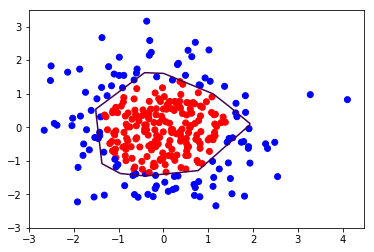

In [35]:
#定义反向传播
STEPS = 20000
BATCH_SIZE = 30
LEARNING_RATE_BASE = 0.001
LEARNING_RATE_DECAY = 0.999
REGULARIZER = 0.01

def backward():
    x = tf.placeholder(tf.float32, shape=(None, 2))
    y_ = tf.placeholder(tf.float32, shape=(None, 1))
    
    X, Y_, Y_c = generateds()
    
    y = forward(x, REGULARIZER)
    
    global_step = tf.Variable(0, trainable=False)
    
    learning_rate = tf.train.exponential_decay(
        LEARNING_RATE_BASE,
        global_step,
        300/BATCH_SIZE,
        LEARNING_RATE_DECAY,
        staircase=True)

    #定义损失函数
    loss_mse = tf.reduce_mean(tf.square(y-y_))
    loss_total = loss_mse + tf.add_n(tf.get_collection('losses'))
    
    #定义反向传播方法，包含正则化
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_total)
    
    with tf.Session() as sess:
        init_op = tf.global_variables_initializer()
        sess.run(init_op)
        for i in range(STEPS):
            start = (i*BATCH_SIZE) % 300
            end = start + BATCH_SIZE
            sess.run(train_step, feed_dict={x: X[start:end], y_:Y_[start:end]})
            if i % 2000 == 0:
                loss_v = sess.run(loss_total, feed_dict={x:X, y_:Y_})
                print("After %d steps, loss is: %f" %(i, loss_v))
                
        xx, yy = np.mgrid[-3:3:.01, -3:3:.01]
        grid = np.c_[xx.ravel(), yy.ravel()]
        probs = sess.run(y, feed_dict={x:grid})
        probs = probs.reshape(xx.shape)
            
    plt.scatter(X[:,0], X[:,1], c=np.squeeze(Y_c))
    plt.contour(xx, yy, probs, levels=[.5])
    plt.show()
        
if __name__=='__main__':
    backward()